In [1]:
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

import numpy as np
from pylab import *
from matplotlib import gridspec
from matplotlib import pyplot as plt


font = {'weight':'regular','family':'sans-serif','size':15}
matplotlib.rc('font', **font)

import mSMOOTH, mFEFF
import os

%matplotlib inline

import peakutils


from scipy.optimize import nnls
from scipy.interpolate import InterpolatedUnivariateSpline

/home/mt/software/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [73]:
def findpeaks(dx,dy):    
    f = InterpolatedUnivariateSpline(dx,dy)
    dxi = np.arange(dx[0], dx[-1]+0.1, 0.05) 
    dyi = f(dxi)
    
    peaks = []
    peaksx = []
    peaksy = []
    peaky = dyi[0]
    for p in range(1,len(dxi)-1):
        if dxi[p] > peaky: 
            peaky = dyi[p]; peakx = dxi[p]; 
            if (dyi[p-1] < peaky) and (dyi[p+1] < peaky) : peaks.append([peakx,peaky,0.5])
    
#     if max(np.array(peaks)[:,1]) < dyi[-1]: peaks.append([dx[-1],dy[-1],0])
    return peaks

def gauss(xin,mu,peakheight,sigma): 
    h=peakheight*np.sqrt(2 * np.pi)*sigma
    gout = h/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (xin - mu)**2 / (2 * sigma**2) )
    return gout 

# ====================================================== 
def peaks2gaus(xin,peaks):
    gaussians = []
    for g in range(len(peaks)):
        g = gauss(ei,peaks[g][0],peaks[g][1],peaks[g][2])
        gaussians.append(g)        

    gaussians_sum = ei*0
    for i in range(len(peaks)):
        gaussians_sum = gaussians_sum+gaussians[i] 
        
    return gaussians, gaussians_sum

# ====================================================== 
def SortPeaks(peaksin):

    peaksout = peaksin.copy()
    
    # sort peaks    
    peaksout = np.array(peaksout,np.float); 
    peaksout = peaksout[peaksout[:,0].argsort()]
    peaksout = list(peaksout)
    #round peaks ( a better way of doing this should exist )
    if peaksout[0][1]   > 0.01 : yround = 4
    elif peaksout[0][1] > 0.001 : yround = 5 
    elif peaksout[0][1] > 0.0001 : yround = 6     
    elif peaksout[0][1] > 0.00001 : yround = 7
    elif peaksout[0][1] > 0.000001 : yround = 8    
    elif peaksout[0][1] > 0.0000001 : yround = 9 
    elif peaksout[0][1] > 0.00000001 : yround = 10
    elif peaksout[0][1] > 0.000000001 : yround = 11   
    else : yround = 11
        
    peaksoutr = []
    for i in peaksout:
        peaksoutr.append([ round(float(i[0]),3), round(float(i[1]),yround), round(float(i[2]),2) ])
    peaksout = peaksoutr  
    
    return peaksout

# ======================================================
def optimize_sigmas(xin,yin,peaksin,omode):

    peaksout = peaksin.copy()    
    
    def optimize_sigma(xin,yin,peakin,omode):
        sigma_range1 = np.linspace(0.1,10,10)
        diffs = []
        sel = (xin <= peakin[0])    
        for i in sigma_range1:
            g = gauss(xin[sel],peakin[0],peakin[1],i)
            diff = yin[sel]-g
            absdiff = []
            for j in range(len(diff)):
                absdiff.append(abs(diff[j]))
            diffs.append([i,sum(absdiff)])        
        diffs = np.array(diffs) 
        diffs = diffs[diffs[:,1].argsort()]       
        sigma_best = diffs[0][0]

        sigma_range2 = np.linspace(sigma_best*0.5,sigma_best*1.5,50)
        diffs = []
        mu = peakin[0]
        if omode == 0: sel = (xin <= mu)
        if omode == 1: sel = (xin >= (mu-sigma_best)) & (xin <= (mu+sigma_best)) 
        if omode == 2: sel = (xin >= (mu-sigma_best/2)) & (xin <= (mu+sigma_best/2))
        if omode == 3: sel = (xin >= (mu)) & (xin <= (mu+sigma_best))
        if omode == 4: sel = (xin >= (mu)) & (xin <= (mu+sigma_best/2))
        if omode == 5: sel = (xin >= (mu-2*sigma_best)) & (xin <= (mu+sigma_best/2))            
        for i in sigma_range2:
            g = gauss(xin[sel],peakin[0],peakin[1],i)
            diff = yin[sel]-g
            absdiff = []
            for j in range(len(diff)):
                absdiff.append(abs(diff[j]))
            diffs.append([i,sum(absdiff)])        
        diffs = np.array(diffs) 
        diffs = diffs[diffs[:,1].argsort()] 
        sigma_best = diffs[0][0] 

        return sigma_best    
    
    residue = yin
    for i in range(len(peaksin)):
        peaksout[i][2] = optimize_sigma(xin,residue,peaksout[i],omode=omode)
        g = gauss(xin,peaksout[i][0],peaksout[i][1],peaksout[i][2])
        residue = residue - g

    peaksout = SortPeaks(peaksout)          
    return peaksout

# ======================================================
def optimize_heights(xin,yin,peaksin,nnnls):
    
    peaksout = peaksin.copy()      
 
    def do_nnls(xin,yin,peaks):
        sel = (xin <= peaks[-1][0]) 
        A = gauss(xin[sel],peaks[0][0],peaks[0][1],peaks[0][2])
        for i in range(1,len(peaks)):
            g = gauss(xin[sel],peaks[i][0],peaks[i][1],peaks[i][2])
            A = np.append(A,g)        
        A = A.reshape(len(xin[sel]),len(peaks),order='F').copy()
        b = yin[sel]    
        out = nnls(A,b) 
        for i in range(len(peaks)):
            if out[0][i] > 0.2: peaks[i][1] = peaks[i][1]*out[0][i]
        return(peaks)
    
    for i in range(nnnls):
        peaksout = do_nnls(xin,yin,peaksout)

    peaksout = SortPeaks(peaksout)          
    return peaksout     


# ======================================================
def optimize_mus(xin,yin,peaksin,dx):
    
    peaksout = peaksin.copy()     
    
    def optimize_mu(xin,yin,peakin,dx):
        mu_range1 = np.linspace(peakin[0]-dx,peakin[0]+dx,50)
        diffs = []
        sel = (xin <= peakin[0])    
        for i in mu_range1:
            g = gauss(xin[sel],i,peakin[1],peakin[2])
            diff = yin[sel]-g
            absdiff = []
            for j in range(len(diff)):
                absdiff.append(abs(diff[j]))
            diffs.append([i,sum(absdiff)])        
        diffs = np.array(diffs) 
        diffs = diffs[diffs[:,1].argsort()]       
        mu_best = diffs[0][0]
        return mu_best

    residue = yin
    for i in range(len(peaksout)):
        peaksout[i][0] = optimize_mu(xin,residue,peaksout[i],dx)
        g = gauss(xin,peaksout[i][0],peaksout[i][1],peaksout[i][2])
        residue = residue - g
         
    peaksout = SortPeaks(peaksout)          
    return peaksout   

# ======================================================
def find_shoulders(xin,yin,peaksin,sigma,toadd=None): 
    
    peaksout = peaksin.copy()
    
    def GaussianSmooth(xin,yin,sigma):  
        delta = xin[1]-xin[0]

        if sigma == 0: sigma = delta

        f  = InterpolatedUnivariateSpline(xin,yin)
        xin = np.arange(min(xin), max(xin), sigma/2)
        yin = f(xin)

        xs = xin; ys = xin*0
        carpan1 = ( delta/( np.sqrt(2*3.14159265359) * sigma) )
        carpan2 = (-2*sigma**2)   

        for i in range(len(xin)):
            for j in range(len(xin)):
                ys[i]=ys[i]+yin[j]*carpan1*np.exp ( ((xin[i]-xin[j])**2)/carpan2 )
        return xs, ys    

    gaussians = []
    for g in range(len(peaks)):
        g = gauss(ei,peaks[g][0],peaks[g][1],peaks[g][2])
        gaussians.append(g)        
    gaussians_sum = ei*0
    for i in range(len(peaks)):
        gaussians_sum = gaussians_sum+gaussians[i]     
    
    xsearch = xin; ysearch = yin - gaussians_sum    
    xsearch, ysearch = GaussianSmooth(xsearch, ysearch, sigma)        
    shoulders = findpeaks(xsearch, ysearch)
      
    for i in shoulders:
        if i[1] <= 0: shoulders.remove(i)
    
    shoulders = np.array(shoulders,np.float);
    shoulders = shoulders[shoulders[:,1].argsort()]
    
    if toadd is None : toadd = [-1,-2]
    
    for i in toadd:
        peaksout.append(list(shoulders[i]))   
    
    peaksout = SortPeaks(peaksout)          
    return peaksout            
            

def plot_peaks(xin,peaksin,peaksABCin,axin):
    
    gaussians, gaussians_sum = peaks2gaus(xin,peaksin)    

    axin.plot(e,c, 'ko', ms=2, lw=0.5, alpha=1)
    axin.plot(ei,ci, 'r-', ms=2, lw=0.5, alpha=1)
    for p in peaks:
        axin.plot(p[0],p[1], 'bo', ms=9, lw=2, alpha=0.7)
    for g in gaussians:    
        axin.plot(ei,g,alpha=0.7)
#     ax.plot(ei,gaussians_sum,alpha=0.7, label='sum of Gaussians')        
    axin.set_xlim(e[0]-2,e[-1]+2)

    peaksABCin = np.array(peaksABCin,np.float)
    gaussians, gaussians_sum = peaks2gaus(xin,peaksABCin)    
    for g in range(len(peaksABCin)): 
        gaussians[g][-1]=0
        axin.fill(ei,gaussians[g],alpha=0.7)
        
#     ax.set_xlim(xin[0],xin[-1])    
#     ax.set_ylim(0,0.5)  


#     ax.set_ylabel('Intensity (a.u.)', fontsize=12)
    ax.set_xlabel('Energy (eV)', fontsize=12)
    
    return

[[401.753, 5.2287, 1.5], [409.103, 2.3176, 2.6], [424.953, 2.8229, 2.31]]

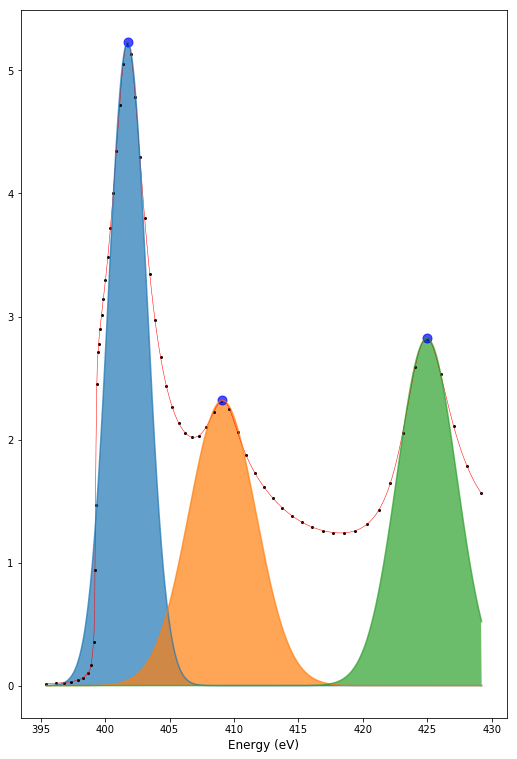

In [88]:
# os.chdir('/home/mt/qm9/all/qm9/selected/000190/')
os.chdir('/home/mt/qm9/all/qm9/selected/102307/')
positions, coulomb_matrix, gr, gr_s, xmu = mFEFF.loadfeff()
os.chdir('/home/mt/gd/research/mJupyter/GaussDecompose')

# ======================================================
fig = plt.figure(figsize=(9,18))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1] )    
gs.update(top=0.93, bottom=0.07, left=0.15, right=0.9, wspace=0.1, hspace=0.1)
ax = fig.add_subplot(gs[0])

# ======================================================
sel = (xmu[0] > 395) & (xmu[0] < 430) # selection
e = xmu[0][sel]; c = xmu[2][sel]

f = InterpolatedUnivariateSpline(e,c)
ei = np.arange(e[0], e[-1]+0.1, 0.05)
ci = f(ei)

# ======================================================
# peaks = findpeaks(ei,ci) 
# peaks = optimize_sigmas(ei,ci,peaks,omode=5)
# peaks = optimize_heights(ei,ci,peaks,nnnls=3)
# peaks = optimize_mus(ei,ci,peaks,dx=1)
peaks =[[401.753, 5.2287, 1.5], [409.103, 2.3176, 2.6], [424.953, 2.8229, 2.31]]


peaksABC = []
peaksABC.append(peaks[0])
peaksABC.append(peaks[1])
peaksABC.append(peaks[2])
plot_peaks(ei,peaks,peaksABC,ax)

plt.savefig("plot1.pdf", format='pdf', dpi=300)
peaks

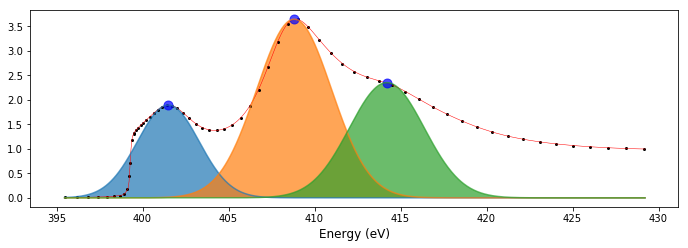

In [82]:
# os.chdir('/home/mt/qm9/all/qm9/selected/000190/')
os.chdir('/home/mt/qm9/all/qm9/selected/000190/')
positions, coulomb_matrix, gr, gr_s, xmu = mFEFF.loadfeff()
os.chdir('/home/mt/gd/research/mJupyter/GaussDecompose')

# ======================================================
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(gs[0])
# ======================================================
sel = (xmu[0] > 395) & (xmu[0] < 430) # selection
e = xmu[0][sel]; c = xmu[2][sel]

f = InterpolatedUnivariateSpline(e,c)
ei = np.arange(e[0], e[-1]+0.1, 0.05)
ci = f(ei)

# ======================================================
peaks = findpeaks(ei,ci) 
peaks =[[401.494, 1.893, 1.8], [408.812, 3.6442, 2.18], [414.204, 2.35, 2.18]]
# peaks = optimize_sigmas(ei,ci,peaks,omode=2)
# peaks = optimize_heights(ei,ci,peaks,nnnls=0)
# peaks = optimize_mus(ei,ci,peaks,dx=1)

peaksABC = []
peaksABC.append(peaks[0])
peaksABC.append(peaks[1])
peaksABC.append(peaks[2])
plot_peaks(ei,peaks,peaksABC,ax)

plt.savefig("plot2.pdf", format='pdf', dpi=300)

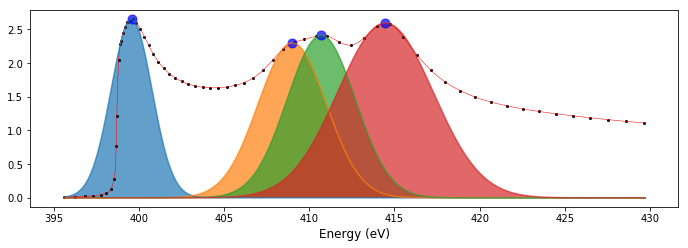

In [83]:
# os.chdir('/home/mt/qm9/all/qm9/selected/000190/')
os.chdir('/home/mt/qm9/all/qm9/selected/091269/')
positions, coulomb_matrix, gr, gr_s, xmu = mFEFF.loadfeff()
os.chdir('/home/mt/gd/research/mJupyter/GaussDecompose')

# ======================================================
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(gs[0])
# ======================================================
sel = (xmu[0] > 395) & (xmu[0] < 430) # selection
e = xmu[0][sel]; c = xmu[2][sel]

f = InterpolatedUnivariateSpline(e,c)
ei = np.arange(e[0], e[-1]+0.1, 0.05)
ci = f(ei)

# ======================================================
peaks = findpeaks(ei,ci) 
# peaks = optimize_sigmas(ei,ci,peaks,omode=1)
# peaks = optimize_heights(ei,ci,peaks,nnnls=3)
# peaks = optimize_mus(ei,ci,peaks,dx=1)
peaks =[[399.5710, 2.65, 1.2], [409, 2.3, 2], [410.7, 2.4120, 2], [414.471, 2.59295, 2.8]]

peaksABC = []
peaksABC.append(peaks[0])
peaksABC.append(peaks[1])
peaksABC.append(peaks[2])
peaksABC.append(peaks[3])
plot_peaks(ei,peaks,peaksABC,ax)

plt.savefig("plot3.pdf", format='pdf', dpi=300)